In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

In [11]:
# Fungsi untuk memuat dataset
def scan_and_load_images(base_folder, target_size=(64, 64)):
    # Data generator dengan rescaling saja (tanpa augmentasi)
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        validation_split=0.2  # 20% untuk validasi
    )

    # Generator untuk training
    train_generator = datagen.flow_from_directory(
        base_folder, 
        target_size=target_size,
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical',  # Multi-class classification
        subset='training',
        shuffle=True
    )

    # Generator untuk validasi
    validation_generator = datagen.flow_from_directory(
        base_folder,
        target_size=target_size,
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator


In [12]:
# Path ke dataset
dataset_path = 'D:\\projek\\FIX\\drowsiness-detection\\new_test_processing'

In [13]:
# Panggil fungsi untuk memuat data
train_generator, validation_generator = scan_and_load_images(dataset_path)

# Print label mapping
print("Class indices:", train_generator.class_indices)


Found 2363 images belonging to 3 classes.
Found 589 images belonging to 3 classes.
Class indices: {'mengantuk': 0, 'menguap': 1, 'tidak_mengantuk': 2}


In [96]:
def build_lenet(input_shape, num_classes):
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dropout(0.4),  # Dropout setelah layer Dense pertama
        Dense(84, activation='relu'),
        Dropout(0.4),  # Dropout setelah layer Dense kedua
        Dense(num_classes, activation='softmax')
    ])
    return model

In [97]:
# Input shape dan jumlah kelas
input_shape = (64, 64, 1)
num_classes = 3  # mengantuk, menguap, tidak_mengantuk

In [98]:
# Inisialisasi model
model = build_lenet(input_shape, num_classes)

In [99]:
# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [100]:
# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

In [101]:
# Training model
print("\n=== Training Model ===")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)



=== Training Model ===
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4288 - loss: 1.0418 - val_accuracy: 0.7029 - val_loss: 0.6892
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6643 - loss: 0.7399 - val_accuracy: 0.7148 - val_loss: 0.5234
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7407 - loss: 0.6013 - val_accuracy: 0.7521 - val_loss: 0.4201
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7665 - loss: 0.4878 - val_accuracy: 0.7810 - val_loss: 0.3504
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7659 - loss: 0.4610 - val_accuracy: 0.7691 - val_loss: 0.3408
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7774 - loss: 0.4502 - val_accuracy: 0.7810 - val_loss: 0.3234
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7802 - loss: 0.4123 - val_accuracy: 0.7861 - val_loss: 0.3142
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7911 - loss: 0


=== Evaluasi Model ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8327 - loss: 0.2548
Validation Loss: 0.2739
Validation Accuracy: 0.7946
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
mengantuk: Optimal Threshold = 0.8377
menguap: Optimal Threshold = 0.0550
tidak_mengantuk: Optimal Threshold = 0.2787


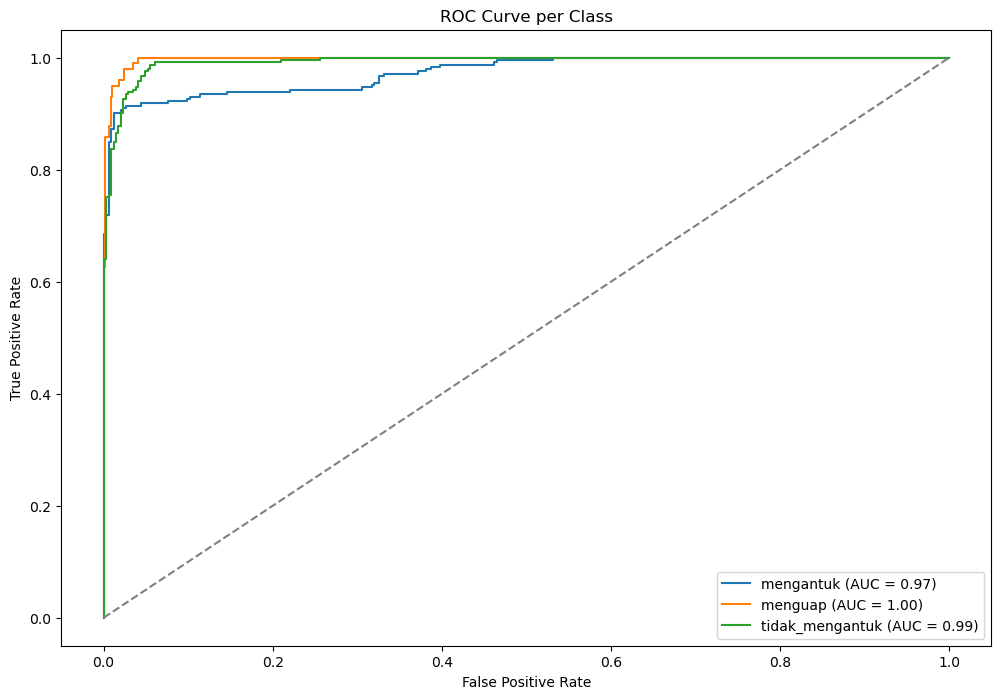

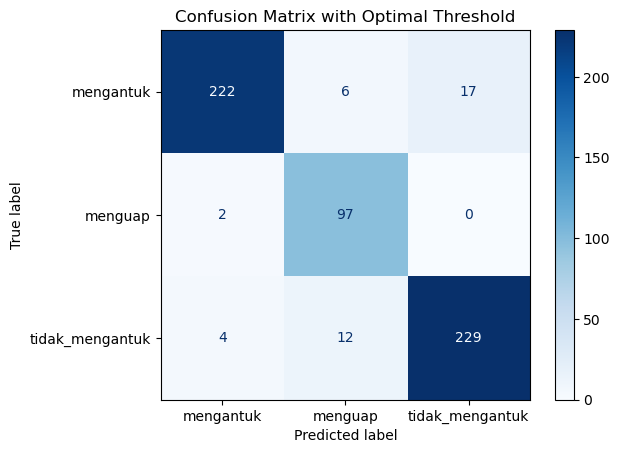


Classification Report (Optimal Threshold):
                 precision    recall  f1-score   support

      mengantuk       0.97      0.91      0.94       245
        menguap       0.84      0.98      0.91        99
tidak_mengantuk       0.93      0.93      0.93       245

       accuracy                           0.93       589
      macro avg       0.92      0.94      0.93       589
   weighted avg       0.93      0.93      0.93       589



In [102]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc

# Evaluasi dengan generator validasi
print("\n=== Evaluasi Model ===")
evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

# Confusion Matrix
validation_generator.reset()
y_probs = model.predict(validation_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = validation_generator.classes

# ROC Curve dan Optimal Threshold untuk setiap kelas
optimal_thresholds = []
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(train_generator.class_indices.keys()):
    fpr, tpr, thresholds = roc_curve((y_true == i).astype(int), y_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Cari threshold optimal
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    print(f"{class_name}: Optimal Threshold = {optimal_threshold:.4f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc='lower right')
plt.show()

# Update Prediksi Menggunakan Optimal Threshold
y_pred_optimal = np.zeros_like(y_probs)

# Terapkan threshold optimal untuk setiap kelas
for i, threshold in enumerate(optimal_thresholds):
    y_pred_optimal[:, i] = (y_probs[:, i] > threshold).astype(int)

# Pilih kelas dengan skor tertinggi setelah thresholding
y_pred_optimal_class = np.argmax(y_pred_optimal, axis=1)

# Confusion Matrix dengan threshold optimal
cm_optimal = confusion_matrix(y_true, y_pred_optimal_class)
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=list(train_generator.class_indices.keys()))
disp_optimal.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Optimal Threshold")
plt.show()

# Classification Report dengan threshold optimal
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal_class, target_names=list(train_generator.class_indices.keys())))


In [ ]:
model.save('cnn_model_mobilenet.h5')
print("Model telah disimpan dalam format .h5")

Validation Accuracy (terakhir): 80.48%
Validation Loss (terakhir): 0.6535


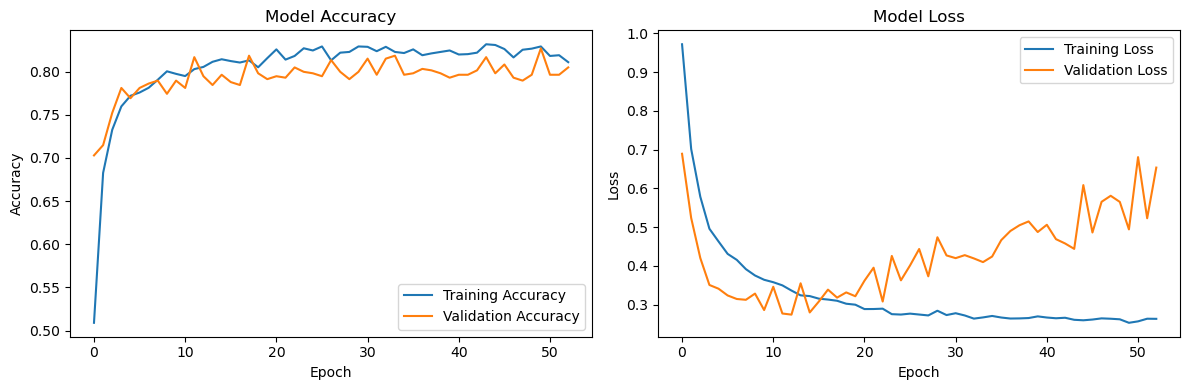

In [103]:

# Mendapatkan nilai terakhir dari validasi akurasi dan loss
final_val_accuracy = history.history.get('val_accuracy', history.history.get('val_categorical_accuracy'))[-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Validation Accuracy (terakhir): {final_val_accuracy * 100:.2f}%")
print(f"Validation Loss (terakhir): {final_val_loss:.4f}")

# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from imutils import face_utils
import dlib

# Load model
model_path = "mobilenet_rgb.h5"
try:
    model = load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model: {e}")
    exit()

# Load predictor untuk landmark wajah
predictor_path = 'data/shape_predictor_68_face_landmarks.dat'
if not os.path.exists(predictor_path):
    print(f"File landmark predictor tidak ditemukan: {predictor_path}")
    exit()

predictor = dlib.shape_predictor(predictor_path)

# Fungsi untuk memproses mata dan mulut
def preprocess_eye_mouth(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Deteksi wajah
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_rgb, 1)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return None

    for face in faces:
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        landmarks = predictor(img_rgb, rect)
        landmarks = face_utils.shape_to_np(landmarks)

        # Ambil mata kiri dan kanan
        left_eye_points = landmarks[36:42]
        right_eye_points = landmarks[42:48]
        mouth_points = landmarks[48:68]

        # Ekstrak bounding box untuk mata dan mulut
        def crop_roi(points):
            (x_min, y_min) = points.min(axis=0)
            (x_max, y_max) = points.max(axis=0)
            roi = img_rgb[y_min:y_max, x_min:x_max]
            return cv2.resize(roi, (224, 224), interpolation=cv2.INTER_CUBIC) / 255.0

        left_eye = crop_roi(left_eye_points)
        right_eye = crop_roi(right_eye_points)
        mouth = crop_roi(mouth_points)

        # Prediksi untuk masing-masing ROI
        left_eye_pred = model.predict(np.expand_dims(left_eye, axis=0))[0]
        right_eye_pred = model.predict(np.expand_dims(right_eye, axis=0))[0]
        mouth_pred = model.predict(np.expand_dims(mouth, axis=0))[0]

        return {
            "left_eye_pred": left_eye_pred,
            "right_eye_pred": right_eye_pred,
            "mouth_pred": mouth_pred,
        }

# Daftar gambar untuk prediksi
image_paths = ["D:\\pcv\\test data\\menguap.jpg", "D:\\pcv\\test data\\merem.jpg"]

# Threshold untuk masing-masing kelas (coba lebih rendah)
THRESHOLD_MENGANTUK = 0.3   # Turunkan threshold untuk mengantuk
THRESHOLD_MENGUAP = 0.5    # Turunkan threshold untuk menguap
THRESHOLD_TIDAK_MENGANTUK = 0.7  # Sesuaikan threshold untuk tidak mengantuk

# Proses prediksi
for image_path in image_paths:
    if not os.path.exists(image_path):
        print(f"Gambar tidak ditemukan: {image_path}")
        continue

    rois = preprocess_eye_mouth(image_path)
    if rois is not None:
        left_eye_pred = rois["left_eye_pred"]
        right_eye_pred = rois["right_eye_pred"]
        mouth_pred = rois["mouth_pred"]

        # Hitung rata-rata prediksi untuk masing-masing label
        mengantuk = (left_eye_pred[0] + right_eye_pred[0] + mouth_pred[1]) / 3
        menguap = (left_eye_pred[1] + right_eye_pred[1] + mouth_pred[1]) / 3
        tidak_mengantuk = (left_eye_pred[2] + right_eye_pred[2] + mouth_pred[2]) / 3

        # Debugging Output
        print(f"Left Eye Prediction: {left_eye_pred}")
        print(f"Right Eye Prediction: {right_eye_pred}")
        print(f"Mouth Prediction: {mouth_pred}")
        print(f"Predictions - Mengantuk: {mengantuk}, Menguap: {menguap}, Tidak Mengantuk: {tidak_mengantuk}")

        # Tentukan label dan confidence berdasarkan threshold
        if mengantuk >= THRESHOLD_MENGANTUK:
            label = "Mengantuk"
            confidence = mengantuk
        elif menguap >= THRESHOLD_MENGUAP:
            label = "Menguap"
            confidence = menguap
        elif tidak_mengantuk >= THRESHOLD_TIDAK_MENGANTUK:
            label = "Tidak Mengantuk"
            confidence = tidak_mengantuk
        

        # Output hasil
        print(f"Image: {image_path}")
        print(f"Predicted Label: {label} (Confidence: {confidence:.2f})\n")
    else:
        print(f"Gagal memproses gambar: {image_path}\n")


Model berhasil dimuat dari: mobilenet_rgb.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Left Eye Prediction: [0.07169342 0.18430223 0.74400425]
Right Eye Prediction: [0.01360001 0.01672971 0.9696702 ]
Mouth Prediction: [0.03004748 0.9679308  0.00202171]
Predictions - Mengantuk: 0.35107473532358807, Menguap: 0.3896542390187581, Tidak Mengantuk: 0.5718986988067627
Image: D:\pcv\test data\menguap.jpg
Predicted Label: Mengantuk (Confidence: 0.35)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Left Eye Prediction: [0.09495877 0.05143284 0.8536083 ]
Right Eye Prediction: [0.06818351 0.05241034 0.87940615]
Mouth Prediction: [0.04348344 0.05823136 0.89828515]
Predictions - Mengantuk: 0.07379121581713359, Menguap: 0.054024845361709595, Tidak Mengantuk: 0.8770998318990072
Image: D:\pcv\test data\merem.jpg
Predicted Label: Tidak Mengantuk (Confidence: 0.88)